In [78]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
import tensorflow as tf
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from src.model import emb_model as Emb_model
from src.train import train_and_get_deep_learning_model

# Task 1
# Initialize data and model

In [58]:
def load_data(path = "./data/preprocessed_train_data.csv", is_np=True):
    train_data = pd.read_csv(path)
    if not is_np:
        return train_data
    X = train_data.iloc[:,:-1]
    X = np.array(X)
    y = train_data["price"]
    y = np.array(y)
    return X, y

In [59]:
X, y = load_data("./data/preprocessed_train_data.csv")
df = pd.read_csv("./data/preprocessed_train_data.csv")
print(X.shape, y.shape)
print(df.shape)

# same random_state as data split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

(16589, 123) (16589,)
(16589, 123) (16589,)
(16589, 124)


(16589, 123) (16589,)
(13271, 123) (13271,) (3318, 123) (3318,)
Epoch 1/400
166/166 [==============================] - 1s 3ms/step - loss: 17830258688.0000 - rmse: 133529.9844 - val_loss: 2571390720.0000 - val_rmse: 50708.8828
Epoch 2/400
166/166 [==============================] - 0s 2ms/step - loss: 2528207872.0000 - rmse: 50281.2891 - val_loss: 1394348928.0000 - val_rmse: 37340.9805
Epoch 3/400
166/166 [==============================] - 0s 2ms/step - loss: 1998107648.0000 - rmse: 44700.1992 - val_loss: 1281703296.0000 - val_rmse: 35800.8828
Epoch 4/400
166/166 [==============================] - 0s 2ms/step - loss: 1853382016.0000 - rmse: 43050.9219 - val_loss: 1135808896.0000 - val_rmse: 33701.7656
Epoch 5/400
166/166 [==============================] - 0s 2ms/step - loss: 1805754752.0000 - rmse: 42494.1719 - val_loss: 1075279104.0000 - val_rmse: 32791.4492
Epoch 6/400
166/166 [==============================] - 0s 2ms/step - loss: 1688681472.0000 - rmse: 41093.5703 - val_loss: 1037702

166/166 [==============================] - 0s 2ms/step - loss: 531358176.0000 - rmse: 23051.2070 - val_loss: 413447680.0000 - val_rmse: 20333.4121
Epoch 103/400
166/166 [==============================] - 0s 2ms/step - loss: 516528384.0000 - rmse: 22727.2617 - val_loss: 522949184.0000 - val_rmse: 22868.0820
Epoch 104/400
166/166 [==============================] - 0s 2ms/step - loss: 591684224.0000 - rmse: 24324.5605 - val_loss: 344719808.0000 - val_rmse: 18566.6309
Epoch 105/400
166/166 [==============================] - 0s 2ms/step - loss: 544277184.0000 - rmse: 23329.7480 - val_loss: 412650432.0000 - val_rmse: 20313.7988
Epoch 106/400
166/166 [==============================] - 0s 2ms/step - loss: 562472832.0000 - rmse: 23716.5098 - val_loss: 363928384.0000 - val_rmse: 19076.9062
Epoch 107/400
166/166 [==============================] - 0s 2ms/step - loss: 526391168.0000 - rmse: 22943.2168 - val_loss: 390885408.0000 - val_rmse: 19770.8223
Epoch 108/400
166/166 [=========================

Epoch 153/400
166/166 [==============================] - 0s 2ms/step - loss: 408606112.0000 - rmse: 20214.0078 - val_loss: 334719776.0000 - val_rmse: 18295.3477
Epoch 154/400
166/166 [==============================] - 0s 2ms/step - loss: 456789376.0000 - rmse: 21372.6309 - val_loss: 381417120.0000 - val_rmse: 19529.9023
Epoch 155/400
166/166 [==============================] - 0s 2ms/step - loss: 444852352.0000 - rmse: 21091.5234 - val_loss: 374731840.0000 - val_rmse: 19357.9922
Epoch 156/400
166/166 [==============================] - 0s 2ms/step - loss: 441107104.0000 - rmse: 21002.5508 - val_loss: 353701408.0000 - val_rmse: 18806.9512
Epoch 157/400
166/166 [==============================] - 0s 2ms/step - loss: 432097216.0000 - rmse: 20786.9473 - val_loss: 334553440.0000 - val_rmse: 18290.8027
Epoch 158/400
166/166 [==============================] - 0s 2ms/step - loss: 481845568.0000 - rmse: 21950.9805 - val_loss: 351915968.0000 - val_rmse: 18759.4238
Epoch 159/400
166/166 [===========

Epoch 204/400
166/166 [==============================] - 0s 2ms/step - loss: 329685472.0000 - rmse: 18157.2422 - val_loss: 341001888.0000 - val_rmse: 18466.2363
Epoch 205/400
166/166 [==============================] - 0s 2ms/step - loss: 369600736.0000 - rmse: 19225.0020 - val_loss: 334344064.0000 - val_rmse: 18285.0781
Epoch 206/400
166/166 [==============================] - 0s 2ms/step - loss: 369610336.0000 - rmse: 19225.2520 - val_loss: 319799712.0000 - val_rmse: 17882.9453
Epoch 207/400
166/166 [==============================] - 0s 2ms/step - loss: 355543744.0000 - rmse: 18855.8672 - val_loss: 343923680.0000 - val_rmse: 18545.1797
Epoch 208/400
166/166 [==============================] - 0s 2ms/step - loss: 388432096.0000 - rmse: 19708.6816 - val_loss: 331427712.0000 - val_rmse: 18205.1562
Epoch 209/400
166/166 [==============================] - 0s 2ms/step - loss: 349283936.0000 - rmse: 18689.1387 - val_loss: 429767456.0000 - val_rmse: 20730.8340
Epoch 210/400
166/166 [===========

Epoch 255/400
166/166 [==============================] - 0s 2ms/step - loss: 328549664.0000 - rmse: 18125.9395 - val_loss: 355922944.0000 - val_rmse: 18865.9199
Epoch 256/400
166/166 [==============================] - 0s 2ms/step - loss: 342429472.0000 - rmse: 18504.8496 - val_loss: 357666240.0000 - val_rmse: 18912.0664
Epoch 257/400
166/166 [==============================] - 0s 2ms/step - loss: 335231840.0000 - rmse: 18309.3379 - val_loss: 427471712.0000 - val_rmse: 20675.3887
Epoch 258/400
166/166 [==============================] - 0s 2ms/step - loss: 312136928.0000 - rmse: 17667.3965 - val_loss: 337344544.0000 - val_rmse: 18366.9414
Epoch 259/400
166/166 [==============================] - 0s 2ms/step - loss: 343485920.0000 - rmse: 18533.3730 - val_loss: 334127680.0000 - val_rmse: 18279.1602
Epoch 260/400
166/166 [==============================] - 0s 2ms/step - loss: 343898272.0000 - rmse: 18544.4941 - val_loss: 382001664.0000 - val_rmse: 19544.8633
Epoch 261/400
166/166 [===========

Epoch 306/400
166/166 [==============================] - 0s 2ms/step - loss: 301304096.0000 - rmse: 17358.1133 - val_loss: 426145824.0000 - val_rmse: 20643.2988
Epoch 307/400
166/166 [==============================] - 0s 2ms/step - loss: 292568384.0000 - rmse: 17104.6309 - val_loss: 423445984.0000 - val_rmse: 20577.8027
Epoch 308/400
166/166 [==============================] - 0s 2ms/step - loss: 285936864.0000 - rmse: 16909.6680 - val_loss: 331964128.0000 - val_rmse: 18219.8828
Epoch 309/400
166/166 [==============================] - 0s 2ms/step - loss: 270434464.0000 - rmse: 16444.8926 - val_loss: 323561856.0000 - val_rmse: 17987.8262
Epoch 310/400
166/166 [==============================] - 0s 2ms/step - loss: 257425728.0000 - rmse: 16044.4922 - val_loss: 372028992.0000 - val_rmse: 19288.0527
Epoch 311/400
166/166 [==============================] - 0s 2ms/step - loss: 278032896.0000 - rmse: 16674.3184 - val_loss: 327426016.0000 - val_rmse: 18094.9160
Epoch 312/400
166/166 [===========

Epoch 357/400
166/166 [==============================] - 0s 2ms/step - loss: 306679744.0000 - rmse: 17512.2734 - val_loss: 324534848.0000 - val_rmse: 18014.8516
Epoch 358/400
166/166 [==============================] - 0s 2ms/step - loss: 258961456.0000 - rmse: 16092.2793 - val_loss: 323100320.0000 - val_rmse: 17974.9922
Epoch 359/400
166/166 [==============================] - 0s 2ms/step - loss: 279380000.0000 - rmse: 16714.6641 - val_loss: 313171584.0000 - val_rmse: 17696.6543
Epoch 360/400
166/166 [==============================] - 0s 2ms/step - loss: 236638416.0000 - rmse: 15383.0557 - val_loss: 330832960.0000 - val_rmse: 18188.8145
Epoch 361/400
166/166 [==============================] - 0s 2ms/step - loss: 287453088.0000 - rmse: 16954.4414 - val_loss: 338419840.0000 - val_rmse: 18396.1914
Epoch 362/400
166/166 [==============================] - 0s 2ms/step - loss: 267002288.0000 - rmse: 16340.2051 - val_loss: 346165824.0000 - val_rmse: 18605.5312
Epoch 363/400
166/166 [===========

<IPython.core.display.Javascript object>


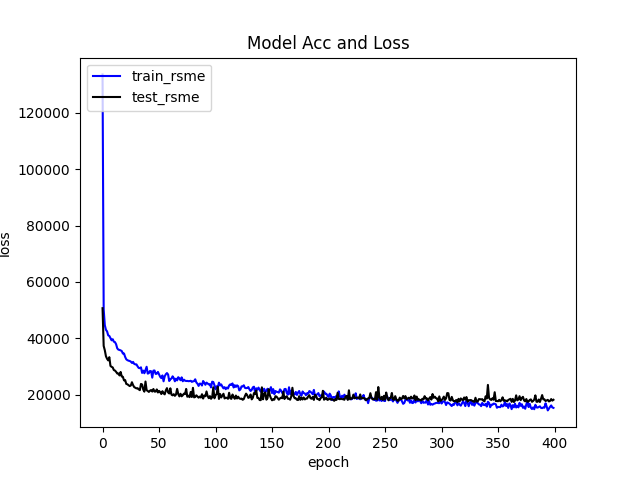

Model: "simple_widedeep_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             multiple                  860       
_________________________________________________________________
dense_81 (Dense)             multiple                  39        
_________________________________________________________________
dense_82 (Dense)             multiple                  4         
_________________________________________________________________
dense_83 (Dense)             multiple                  36        
_________________________________________________________________
dense_84 (Dense)             multiple                  156       
_________________________________________________________________
dense_85 (Dense)             multiple                  1240      
_________________________________________________________________
dense_86 (Dense)             multiple      

In [60]:
# train or load model

# baseline model
baseline_model = load_model("./models/baseline_model.h5")

# embedded model
emb_model = Emb_model()
emb_model.load_weights("./models/emb_model")

# random forest
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=2021)
# rf_regressor.fit(X_tree_train, y_tree_train)
rf_regressor.fit(X_train, y_train)

# gradient boost 
gb_regressor = GradientBoostingRegressor(n_estimators=400, learning_rate=0.15, random_state=2021)
# gb_regressor.fit(X_tree_train, y_tree_train)
gb_regressor.fit(X_train, y_train)

# wide & deep model
wnd_model = train_and_get_deep_learning_model("simple_widedeep")

## RMSE in different test part

In [70]:
def rmse_in_different_test_part():
    # import data
    kfold = KFold(n_splits=5)
    bl_rmse = []
    eb_rmse = []
    rf_rmse = []
    gb_rmse = []
    wnd_rmse = []
    ensemble_rmse = []


    for _, test in kfold.split(X_test, y_test):
        bl_predict = np.squeeze(baseline_model.predict(X_test[test]))
        bl_rmse.append(mean_squared_error(y_test[test], bl_predict, squared=False))
        
        eb_predict = np.squeeze(emb_model.predict(X_test[test]))
        eb_rmse.append(mean_squared_error(y_test[test], eb_predict, squared=False))

        rf_predict = rf_regressor.predict(X_test[test])
        rf_rmse.append(mean_squared_error(y_test[test], rf_predict, squared=False))

        gb_predict = gb_regressor.predict(X_test[test])
        gb_rmse.append(mean_squared_error(y_test[test], gb_predict, squared=False))
        
        wnd_predict = np.squeeze(wnd_model.predict(X_test[test]))
        wnd_rmse.append(mean_squared_error(y_test[test], wnd_predict, squared=False))

        ensemble_predict = 0.2 * gb_predict + 0.2 * rf_predict + 0.3 * bl_predict + 0.3 * eb_predict
        ensemble_rmse.append(mean_squared_error(y_test[test], ensemble_predict, squared=False))

    x = range(1, 6)
    plt.figure(figsize=(9,6))
    plt.plot(x, bl_rmse, c="r", label="BaselineModel_RMSE")
    plt.plot(x, eb_rmse, c="pink", label="EmbeddedModel_RMSE")
    plt.plot(x, rf_rmse, c="y", label="RandomForest_RMSE")
    plt.plot(x, gb_rmse, c="b", label="GradientBoosting_RMSE")
    plt.plot(x, wnd_rmse, c="grey", label="Wide&Deep_RMSE")
    plt.plot(x, ensemble_rmse, c="black", label="ensemble_RMSE")
    
    plt.xlabel("Set No.")
    plt.ylabel("RMSE")
    plt.xticks(np.arange(1, 6, 1), [f"test set {i}" for i in range(1, 6)])
    plt.legend()
    plt.show()
    plt.savefig("x1 RMSE in different part.png")


<IPython.core.display.Javascript object>


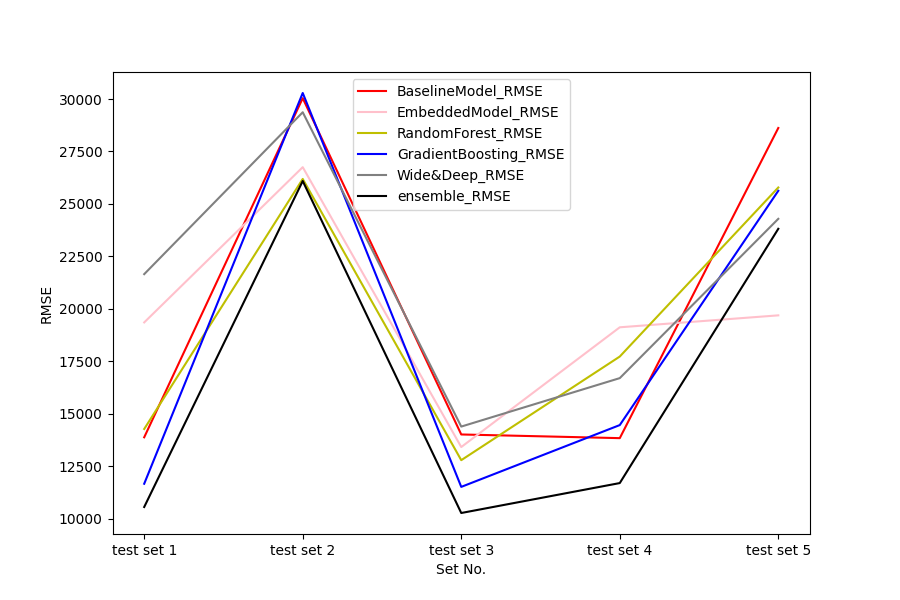

In [71]:
rmse_in_different_test_part()

## Price-Quantile

In [72]:
def price_quantile():
    df_y = [df.quantile(i*0.01).price for i in range(0, 101)]
    df_x = [(i)*0.01 for i in range(len(df_y))]
    quarter_y = [df.quantile(i*0.1).price for i in range(11)]
    quarter_x = [(i)*0.1 for i in range(11)]

    plt.figure(figsize=(9,6))
#     plt.scatter(df_x, df_y)
    plt.plot(df_x, df_y)
    plt.scatter(quarter_x, quarter_y, c='r', label="Price with quantile{0.0,0.1,....1.0}")
    
    plt.xlabel("Quantile")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    plt.savefig("x2 price of different quantile.png")

<IPython.core.display.Javascript object>


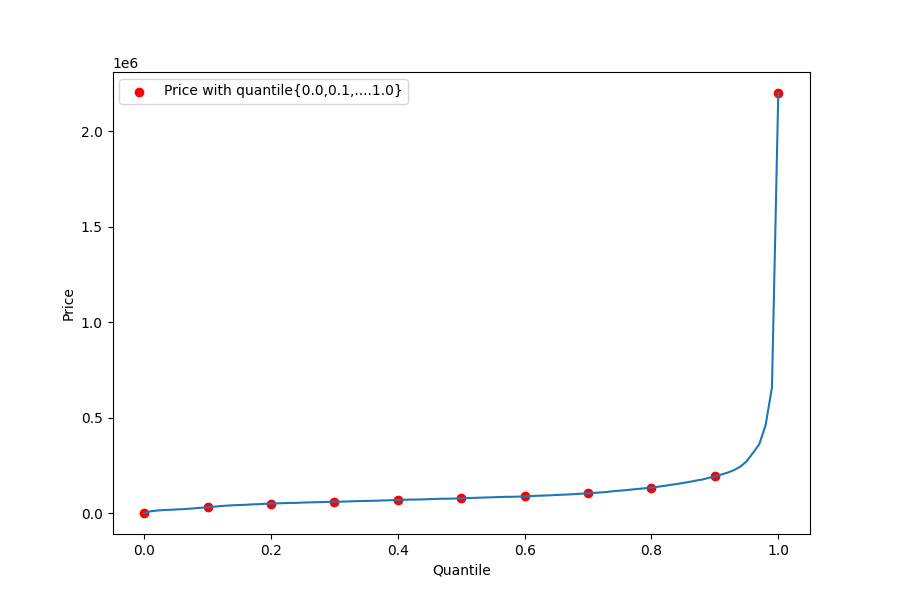

In [73]:
price_quantile()

## RMSE in different price range

In [67]:
# compute rmse in given price range
def rmse_in_one_price_range(left_quantile=0, right_quantile=1):
    xy_test = np.column_stack((X_test, y_test))
    xy_test_price = xy_test[df.quantile(left_quantile).price <= xy_test[:,-1]]
    xy_test_price = xy_test_price[xy_test_price[:,-1] < df.quantile(right_quantile).price]
    
#     xy_tree_test = np.column_stack((X_tree_test, y_tree_test))
#     xy_tree_test_price = xy_tree_test[df.quantile(left_quantile).price <= xy_tree_test[:,-1]]
#     xy_tree_test_price = xy_tree_test_price[xy_tree_test_price[:,-1] < df.quantile(right_quantile).price]
    
    def compute_rmse(X, y):
        bl_predict = np.squeeze(baseline_model.predict(X))
        bl_rmse = mean_squared_error(y, bl_predict, squared=False)

        eb_predict = np.squeeze(emb_model.predict(X))
        eb_rmse = mean_squared_error(y, eb_predict, squared=False)

        rf_predict = rf_regressor.predict(X)
        rf_rmse = mean_squared_error(y, rf_predict, squared=False)

        gb_predict = gb_regressor.predict(X)
        gb_rmse = mean_squared_error(y, gb_predict, squared=False)
        
        wnd_predict = np.squeeze(wnd_model.predict(X))
        wnd_rmse = mean_squared_error(y, wnd_predict, squared=False)

        ensemble_predict = 0.2 * gb_predict + 0.2 * rf_predict + 0.3 * bl_predict + 0.3 * eb_predict
        ensemble_rmse = mean_squared_error(y, ensemble_predict, squared=False)
        
        return bl_rmse, eb_rmse, rf_rmse, gb_rmse, wnd_rmse, ensemble_rmse
    
    return compute_rmse(xy_test_price[:,:-1], xy_test_price[:,-1])

In [74]:
def rmse_in_different_price_range():
    bl_rmse_lst = []
    eb_rmse_lst = []
    rf_rmse_lst = []
    gb_rmse_lst = []
    wnd_rmse_lst = []
    ensemble_rmse_lst = []
    for i in range(10):
        bl_rmse, eb_rmse, rf_rmse, gb_rmse, wnd_rmse, ensemble_rmse = rmse_in_one_price_range(i*0.1, (i+1)*0.1)
        bl_rmse_lst.append(bl_rmse)
        eb_rmse_lst.append(eb_rmse)
        rf_rmse_lst.append(rf_rmse)
        gb_rmse_lst.append(gb_rmse)
        wnd_rmse_lst.append(wnd_rmse)
        ensemble_rmse_lst.append(ensemble_rmse)
    x = [i*0.1 for i in range(10)]
    
    
    plt.figure(figsize=(9,6))
    plt.plot(x, bl_rmse_lst, c="r", label="BaselineModel_RMSE")
    plt.plot(x, bl_rmse_lst, c="pink", label="EmbeddedModel_RMSE")
    plt.plot(x, rf_rmse_lst, c="y", label="RandomForest_RMSE")
    plt.plot(x, gb_rmse_lst, c="b", label="GradientBoosting_RMSE")
    plt.plot(x,wnd_rmse_lst, c="grey", label="Wide&Deep_RMSE")
    plt.plot(x, ensemble_rmse_lst, c="black", label="ensemble_RMSE")
    
    plt.xlabel("Price Range(in quantile)")
    plt.ylabel("RMSE")
    
    plt.xticks(x, [f"[{round(i, 1)}, {round(i+0.1, 1)})" for i in x])
    plt.legend()
    plt.show()
    plt.savefig("x3 RMSE in different price ranges.png")

<IPython.core.display.Javascript object>


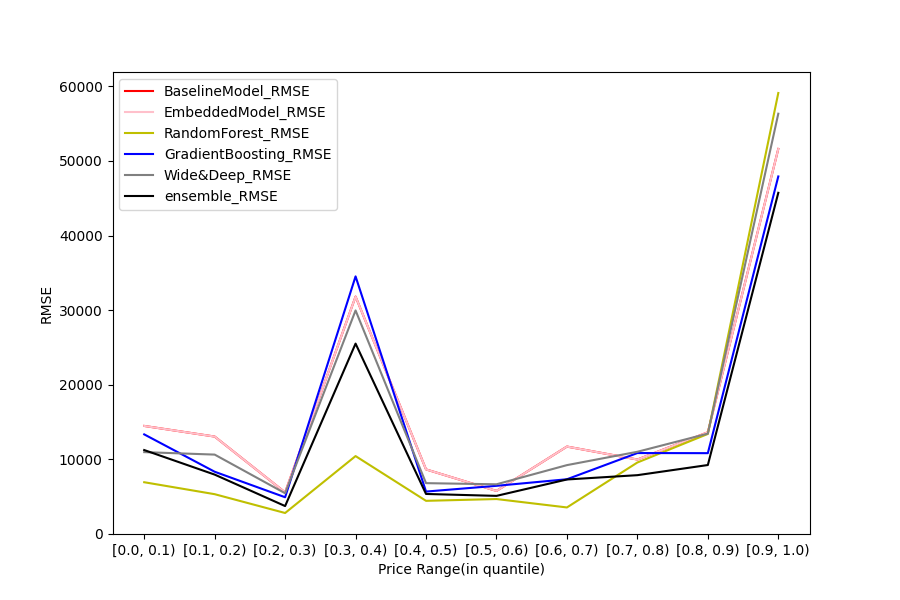

In [75]:
rmse_in_different_price_range()

# Task 3

In [76]:
def load_data(path = "./data/preprocessed_data_task3.csv"):

    train_data = pd.read_csv(path)

    X = train_data.iloc[:,0:-1]
    X = np.array(X)
    y = train_data["pred"]
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

(4463, 53) (4463,) (1116, 53) (1116,)


In [79]:
# train

dt = DecisionTreeRegressor(max_depth=100)
dt.fit(x_train, y_train)

rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=2021)
rf.fit(x_train, y_train)

gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.15, max_features='sqrt', random_state=2021)
gb.fit(x_train, y_train)


GradientBoostingRegressor(learning_rate=0.15, max_features='sqrt',
                          n_estimators=300, random_state=2021)

In [80]:
dt_predict = dt.predict(x_test)
dt_rmse = mean_squared_error(y_test, dt_predict, squared=False)

rf_predict = rf.predict(x_test)
rf_rmse = mean_squared_error(y_test, rf_predict, squared=False)

gb_predict = gb.predict(x_test)
gb_rmse = mean_squared_error(y_test, gb_predict, squared=False)

In [81]:
print(dt_rmse, rf_rmse, gb_rmse)

0.2064706984295075 0.15199629539484402 0.12198192319786115


In [88]:
def rmse_in_different_test_part():
    kfold = KFold(n_splits=5)
    dt_rmse = []
    rf_rmse = []
    gb_rmse = []
    for _, test in kfold.split(x_test, y_test):
        dt_predict = dt.predict(x_test[test])
        dt_rmse.append(mean_squared_error(y_test[test], dt_predict, squared=False))

        rf_predict = rf.predict(x_test[test])
        rf_rmse.append(mean_squared_error(y_test[test], rf_predict, squared=False))

        gb_predict = gb.predict(x_test[test])
        gb_rmse.append(mean_squared_error(y_test[test], gb_predict, squared=False))

    x = range(1, 6)
    plt.figure(figsize=(9,6))
    plt.plot(x, dt_rmse, c="r", label="DecisionTree_RMSE")
    plt.plot(x, rf_rmse, c="pink", label="RandomForest_RMSE")
    plt.plot(x, gb_rmse, c="y", label="GradientBoost_RMSE")

    plt.xlabel("Set No.")
    plt.ylabel("RMSE")
    plt.xticks(np.arange(1, 6, 1), [f"test set {i}" for i in range(1, 6)])
    plt.legend()
    plt.show()
    plt.savefig("x4 RMSE in different part.png")

<IPython.core.display.Javascript object>


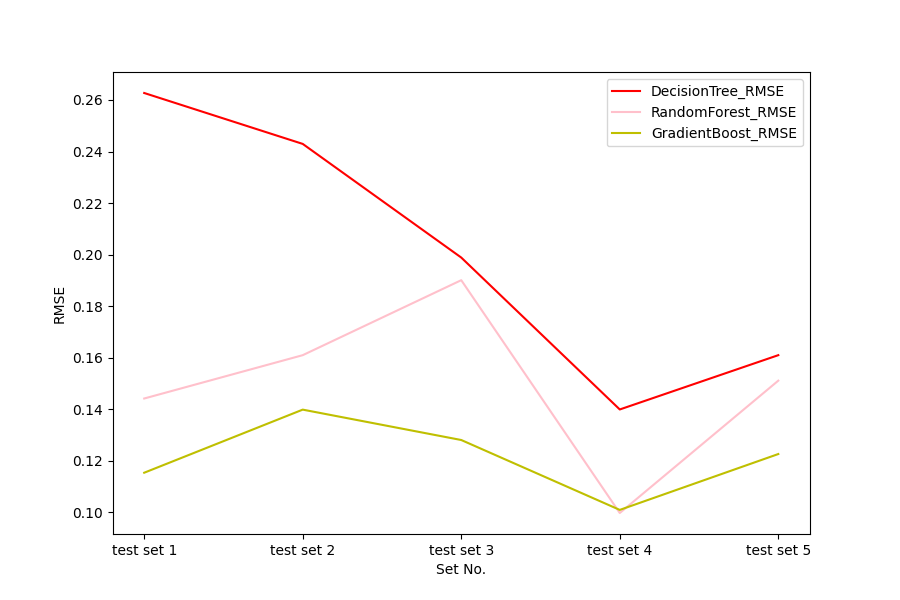

In [89]:
rmse_in_different_test_part()